Ocular Disease Detection using Deep Learning

---



* Anurag Ratnaparkhe (19229992)
* Dhanshree Bauskar (19230460)
* Dhwani Dharmesh Hingu (19216742)
* Mardwin Alejandro Cardenas Rodriguez (20144237)

In [2]:
#Visualization  and Data Transformation Libraries
pip install keras-metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.pyplot import figure
import seaborn as sns
#OS library
import os

#Image Pre-Processing
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import keras.preprocessing.image as img
#Keras-Tensorflow DL Libraries
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
#Keras Metrics
import keras_metrics # for Precision and Recall Metrics
from tensorflow.keras import metrics
#CNN Libraries
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import InputLayer

#Sci-Kit Learn Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#Other Misc. Libraries for operations
import random as rn
import cv2                  
from tqdm import tqdm               
from random import shuffle  
from zipfile import ZipFile

In [3]:
# Required instances to download kaggle data
! pip install sklearn
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
#Data gathering directly from Kaggle
! kaggle datasets download andrewmvd/ocular-disease-recognition-odir5k

ocular-disease-recognition-odir5k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
#unzip data folder into Collab
from zipfile import ZipFile
# Create a ZipFile Object and load sample.zip in it
with ZipFile('ocular-disease-recognition-odir5k.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

Data freame creation to select data from folder

In [6]:
#XLSX reader 
import pandas as pd
import cv2
import numpy as np
from pathlib import Path

df = pd.read_excel('/content/ODIR-5K/ODIR-5K/data.xlsx', index_col= False ) 

left = df[["Left-Fundus", "Left-Diagnostic Keywords"]]
left.rename(columns={"Left-Fundus": "id", "Left-Diagnostic Keywords": "tag"}, inplace=True)
right = df[["Right-Fundus", "Right-Diagnostic Keywords"]]
right.rename(columns={"Right-Fundus": "id", "Right-Diagnostic Keywords": "tag"},inplace=True)


frames = [left, right]
data2 = pd.concat(frames)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
dataset2 = data2[(data2["tag"] == "normal fundus" )| (data2["tag"] == "pathological myopia")| (data2["tag"] == "catarect")| (data2["tag"] == "wet age-related macular degeneration")|  (data2["tag"] == "diabetic retinopathy")| (data2["tag"] == "glaucoma")| (data2["tag"] == "hypertensive retinopathy")| (data2["tag"] == "dry age-related macular degeneration")]

In [9]:
#Class distribution
dataset2['tag'].value_counts()

normal fundus                           2816
pathological myopia                      227
glaucoma                                 200
dry age-related macular degeneration     196
hypertensive retinopathy                 104
wet age-related macular degeneration      41
diabetic retinopathy                      15
Name: tag, dtype: int64

In [10]:
#rename pics with the same label 
dataset2 = dataset2.replace({'wet age-related macular degeneration': 'MacularDegeneration'})
dataset2 = dataset2.replace({'dry age-related macular degeneration': 'MacularDegeneration'})
sub_dataset = dataset2[dataset2['tag'] == 'normal fundus']

In [13]:
#Undersampling
df = sub_dataset.sample(300).reset_index(drop=True) 
clean = dataset2[dataset2['tag'] != 'normal fundus']
frames2 = [clean, df]
newClean = pd.concat(frames2)

In [17]:
#New Data Distribution
newClean['tag'].value_counts()

normal fundus               300
MacularDegeneration         237
pathological myopia         227
glaucoma                    200
hypertensive retinopathy    104
diabetic retinopathy         15
Name: tag, dtype: int64

([0, 1, 2, 3, 4, 5], <a list of 6 Text major ticklabel objects>)

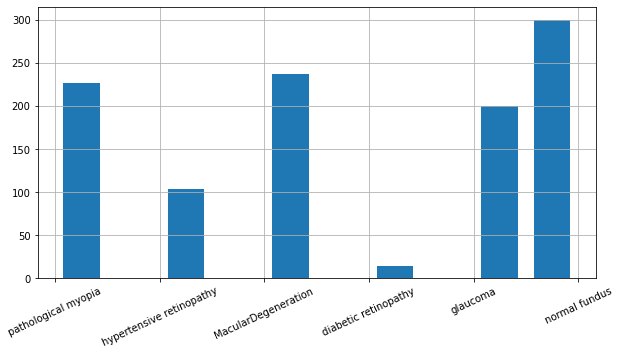

In [19]:
#Class imbalance visualization
newClean['tag'].hist(figsize = (10, 5), rwidth = .7)
plt.xticks(rotation = 25)

In [21]:
#Data directory
img_dir = "/content/ODIR-5K/ODIR-5K/Training Images"
#Image generator creator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2, #horizontal shift 
    zoom_range=0.2, #zoom
    horizontal_flip=True, #horizontal flip
    brightness_range=[0.2,0.8], ## brightness
    validation_split=0.2) # set validation split
#Input size images
img_size = 256
img_width = 256
batch_size = 1083

In [22]:
#Reading the images from the dataframe path
train_generator=train_datagen.flow_from_dataframe(
    dataframe=newClean,
    directory='/content/ODIR-5K/ODIR-5K/Training Images',
    x_col="id",
    y_col="tag",
    batch_size=1083,
    seed=42, #setting the seed for reusability
    shuffle=True,
    class_mode="categorical", #as this is a multi-class classification probelem.
    target_size=(img_size,img_size),validate_filenames=False)

Found 1083 non-validated image filenames belonging to 6 classes.


In [23]:
train_image_data, train_labels = train_generator.next()
#train_image_data[0]
train_image_data.shape

(1083, 256, 256, 3)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


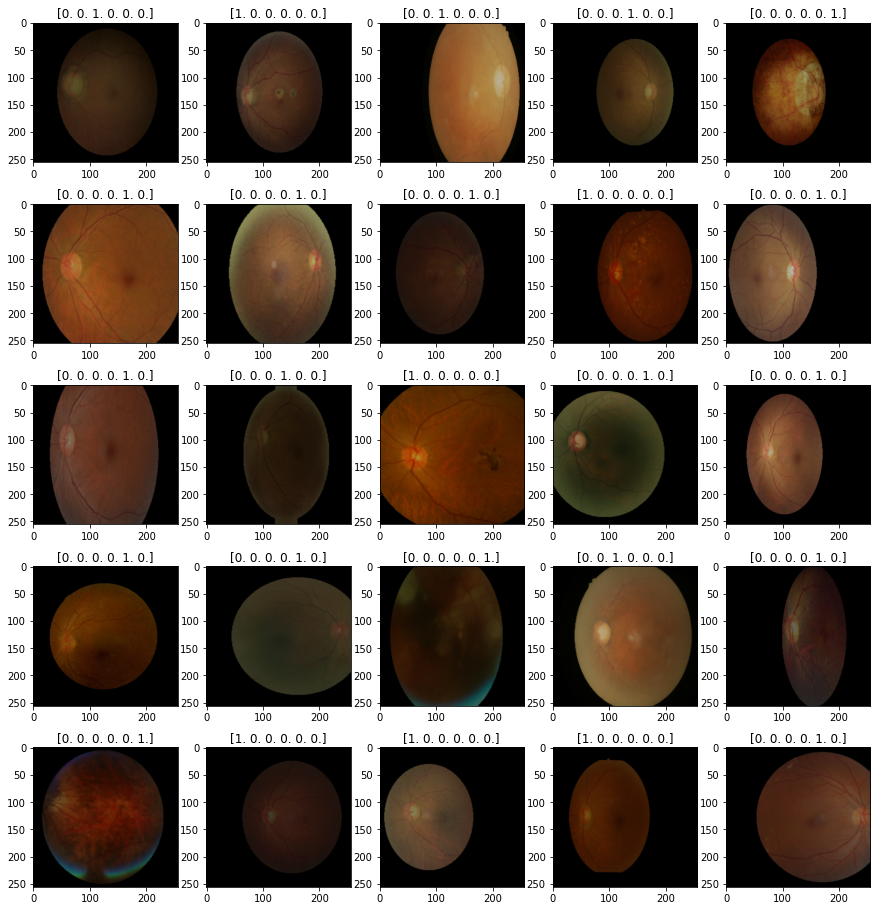

In [24]:
#Plotting a few examples
fig,ax=plt.subplots(5,5) # Setting the Matrix of Images
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=.3) 
fig.set_size_inches(15,30) # Setting the plot Size
#Plotting
for i in range(5):
    for j in range (5):
        l=rn.randint(0,len(train_labels))
        ax[i,j].imshow(train_image_data[l][:])
        ax[i,j].set_title(train_labels[l])
        ax[i,j].set_aspect('auto')

In [25]:
#Splitting the dataset into trainning and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_image_data, train_labels, test_size=0.20)

In [26]:
#Dowloading ResNet50 with 256,256,3 as the input shape
base_model=ResNet50(include_top=False, weights='imagenet',input_shape=(256,256,3), pooling='max')
#model summary
print("The summary of the downloaded model is:")
base_model.summary()

The summary of the downloaded model is:
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________

In [37]:
#Setting additional Model Parameters on top of the downloaded base_model

model=Sequential() #Using a Sequential Architecture
model.add(base_model)
model.add(Dropout(0.50))
model.add(Dense(8192,activation='relu'))
model.add(Dense(4096,activation='relu'))
model.add(Dense(2048,activation='relu'))
#model.add(Dropout(0.30))
model.add(Dense(1024,activation='relu'))
#model.add(Dropout(0.20))
model.add(Dense(512,activation='relu'))
model.add(Dense(6,activation='softmax')) #as this is a multclass classification problem

In [38]:
#Setting the number of Epochs and Batch Size for the model to train on
epochs=30
batch_size=1083
#Manipulating the learning rate when the results hit a plateau
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=2, verbose=1)
#Setting the Trainable Propoerty to be True
base_model.trainable= True 
#Compiling the Final Model with requesting accuracy, precision and recall as the metrics
model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy',keras_metrics.precision(), keras_metrics.recall()])
print("The Summary of the final model is:")
model.summary()

The Summary of the final model is:
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 8192)              16785408  
_________________________________________________________________
dense_9 (Dense)              (None, 4096)              33558528  
_________________________________________________________________
dense_10 (Dense)             (None, 2048)              8390656   
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_12 (Dense)   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [39]:
#Fitting the model and evaluating on the validation dataset, while printing Accuracy, Precision, Recall for each epoch
History = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test,y_test))

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


28/28 [==============================] - 18s 450ms/step - loss: 2.1341 - accuracy: 0.2864 - precision: 0.1393 - recall: 0.0985 - val_loss: 1.8309 - val_accuracy: 0.2350 - val_precision: 0.1667 - val_recall: 0.0654
Epoch 2/30
28/28 [==============================] - 12s 412ms/step - loss: 1.4448 - accuracy: 0.4353 - precision: 0.2344 - recall: 0.0842 - val_loss: 1.6224 - val_accuracy: 0.2903 - val_precision: 0.2550 - val_recall: 0.0841
Epoch 3/30
28/28 [==============================] - 12s 414ms/step - loss: 1.1722 - accuracy: 0.5335 - precision: 0.3166 - recall: 0.1049 - val_loss: 1.8212 - val_accuracy: 0.2396 - val_precision: 0.3489 - val_recall: 0.1190
Epoch 4/30
28/28 [==============================] - 12s 418ms/step - loss: 1.0748 - accuracy: 0.5855 - precision: 0.3896 - recall: 0.1351 - val_loss: 1.5857 - val_accuracy: 0.3548 - val_precision: 0.4164 - val_recall: 0.1426
Epoch 5/30
28/28 [==============================] - 12s 419ms/step - loss: 0.9759 - accuracy: 0.6212 - precisio

In [30]:
#Saving The Model
model.save('final_model/model.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [31]:
def plot_metrics(parameter):
  #Setting the Figure Size
  figure(figsize=(15, 10))
  #Getting the train parameter curve
  plt.plot(History.history[parameter])
  #Getting the validation parameter curve
  plt.plot(History.history['val_'+parameter])
  #Setting title and x and y labels
  plt.title('Model '+parameter, fontsize=20)
  plt.ylabel(parameter, fontsize=10)
  plt.xlabel('Epochs', fontsize=10)
  plt.legend(['train', 'validation'])
  plt.show()

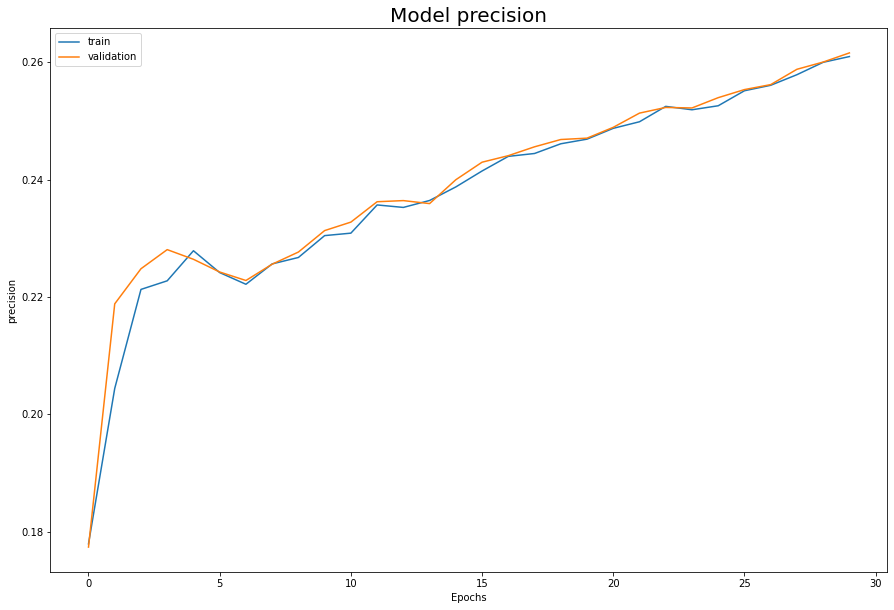

In [32]:
# plotting the precision on epochs.
plot_metrics('precision')

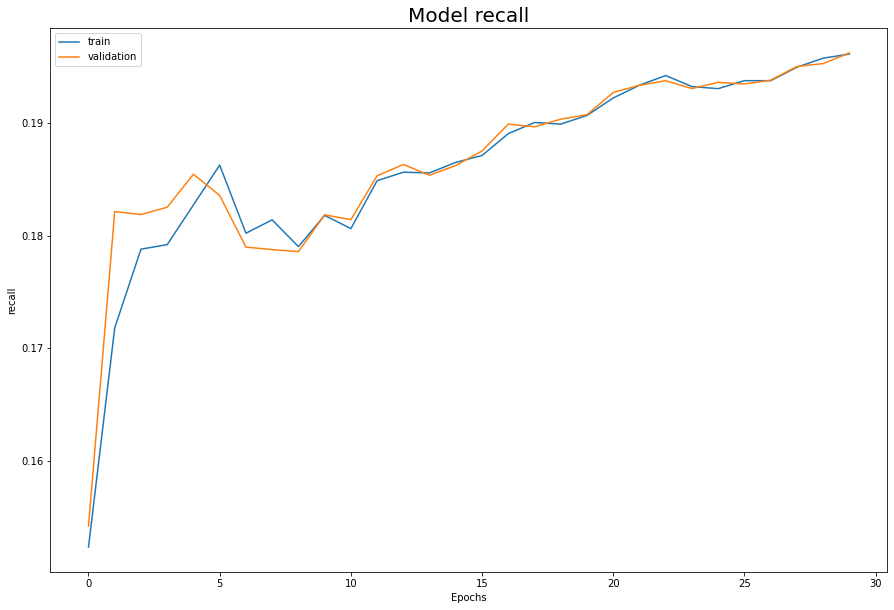

In [33]:
#plotting the recall on epochs.
plot_metrics('recall')

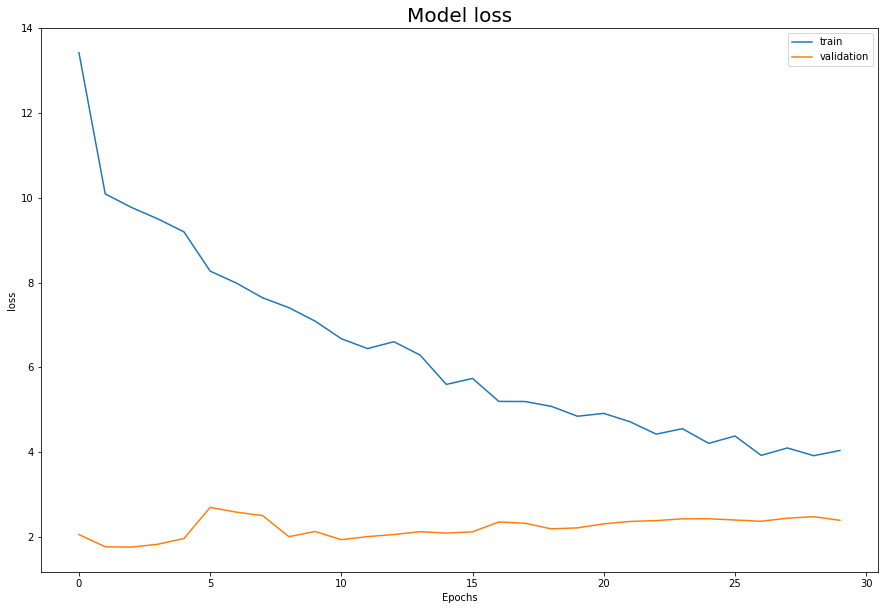

In [34]:
#plotting the loss function on epochs.
plot_metrics('loss')

In [ ]:
path_file= '/content/ODIR-5K/ODIR-5K/Training Images/_left.jpg'
X = cv2.imread(path_file,cv2.IMREAD_COLOR)
X = cv2.resize(X,(256,256))
#Plotting the Image
plt.figure()
plt.imshow(X[:,:,::-1]) 
plt.show()  
X = np.array(X)
X = np.expand_dims(X, axis=0)
# make probability predictions with the model
predictions = model.predict(X)
print(predictions)
# round predictions 
#rounded = [round(x[0]) for x in predictions]
y_pred = np.round(model.predict(X))
print(y_pred)